# Adding multiple chips to wafer

In [33]:
def add_dxf_chip_to_wafer(wafer, dxf_filename, path, chip_width, idx, layer_in=0, 
                          layer_out=5, x_offset=0, y_offset=0, add_bool = True):
    """
    Imports a? GDS file converted from a DXF filename, copies a layer, and places it on the wafer.
    Args:
        wafer: phidl Device to add chip to
        dxf_filename: str, filename ending in .dxf
        path: str, directory containing the GDS files
        chip_width: int, spacing between chips
        idx: int, index for chip placement
        layer_in: int, layer to copy from
        layer_out: int, layer to copy to
        x_offset: int, additional x offset for chip placement
        y_offset: int, additional y offset for chip placement
        add_bool: bool, whether to add the chip to the wafer or not
    """
    gds_filename = dxf_filename.replace('.dxf', '.gds')
    file_path = os.path.join(path, gds_filename)
    print(f"Importing {file_path}")
    imported = pg.import_gds(file_path)
    copied = pg.copy_layer(imported, layer=layer_in, new_layer=layer_out)
    x_pos = idx * chip_width + x_offset
    y_pos = y_offset

    # make a bounding box for the chip
    if add_bool:
        wafer << copied.move((x_pos, y_pos))
    return wafer, copied

# Example usage:
# add_dxf_chip_to_wafer(wafer, 'TESTINGQUBIT1111-C1A.dxf', path, qubit_chip_width, 0, x_offset=1000, y_offset=500)


In [34]:

import os
import phidl.geometry as pg
from phidl import Device, quickplot as qp

# Create a blank wafer layout
wafer = Device("wafer_layout")

# Add wafer outline (2-inch wafer = 5.08 cm = 50,800 um diameter)
wafer_radius = 45000   # um
wafer << pg.circle(radius=wafer_radius, layer=0)


DeviceReference (parent Device "circle", ports [], origin (0, 0), rotation 0, x_reflection False)

### Qubit

In [35]:
def add_qubit_bbox_and_negative_mask(wafer, qubit_chip_obj, qubit_chip_width, idx, xpos_offset, ypos_offset):
    qubit_length = 16550  # Example length for qubit chip, adjust as needed
    test_structure_length_down = 9850
    test_structure_length_up = 2100

    xpos = xpos_offset + (idx * qubit_chip_width)
    ypos = ypos_offset

    # qubit_bbox = pg.rectangle(size=(qubit_chip_width, qubit_length), layer=13)
    # wafer << qubit_bbox.move((xpos -200, ypos-200  + test_structure_length_down))
    qubit_bbox = pg.rectangle(size=(qubit_chip_width, qubit_length + test_structure_length_down - 250), layer=13)
    wafer << qubit_bbox.move((xpos -200, ypos-200+100))
    # test_structure_bbox = pg.rectangle(size=(qubit_chip_width, test_structure_length_down), layer=13)
    # wafer << test_structure_bbox.move((xpos - 200, ypos - 200))

    qubit_chip_bbox = pg.rectangle(size=(qubit_chip_width, qubit_length + test_structure_length_down + test_structure_length_up), layer=14)
    qubit_chip_bbox.move((-200, -200))

    qubit_negative = pg.boolean(A=qubit_chip_bbox, B=qubit_chip_obj, operation='xor', layer=5)
    wafer << qubit_negative.move((xpos, ypos))
    # wafer<< qubit_chip_obj.move((xpos, ypos))

    return wafer, qubit_negative, qubit_bbox


Importing C:\Users\eeshg\Documents\multimode_sims\Design\coupler\LMM3_Dravid\designs_dxf\DRAVIDQUBIT_SKINNY_JUNCS-Q1.gds
Importing C:\Users\eeshg\Documents\multimode_sims\Design\coupler\LMM3_Dravid\designs_dxf\DRAVIDQUBIT_SKINNY_JUNCS-Q2.gds
Importing C:\Users\eeshg\Documents\multimode_sims\Design\coupler\LMM3_Dravid\designs_dxf\DRAVIDQUBIT_SKINNY_JUNCS-Q3.gds
Importing C:\Users\eeshg\Documents\multimode_sims\Design\coupler\LMM3_Dravid\designs_dxf\DRAVIDQUBIT_SKINNY_JUNCS-Q4.gds
Importing C:\Users\eeshg\Documents\multimode_sims\Design\coupler\LMM3_Dravid\designs_dxf\DRAVIDQUBIT_SKINNY_JUNCS-Q5.gds
Importing C:\Users\eeshg\Documents\multimode_sims\Design\coupler\LMM3_Dravid\designs_dxf\DRAVIDQUBIT_SKINNY_JUNCS-Q6.gds
Importing C:\Users\eeshg\Documents\multimode_sims\Design\coupler\LMM3_Dravid\designs_dxf\DRAVIDQUBIT_SKINNY_JUNCS-Q7.gds
Importing C:\Users\eeshg\Documents\multimode_sims\Design\coupler\LMM3_Dravid\designs_dxf\DRAVIDQUBIT_SKINNY_JUNCS-Q8.gds
Importing C:\Users\eeshg\Documen

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


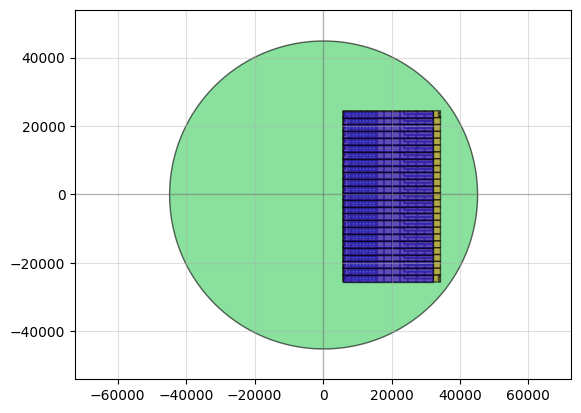

In [36]:

# Qubits 
# Define path to DXF file to import
qubit_chip_width = 2000 # um 
# path = r"C:\Users\eeshg\Documents\multimode_sims\Design\coupler"  # <-- UPDATE THIS
path = ''
with open("chip_names_qubit.txt", "r") as f:
    chip_names_read = [line.strip() for line in f.readlines()]
dxf_files = chip_names_read
# x pos and y pos offsets for the qubit chips
xpos_offset = -7000 - 20000 + 1251.5 -1.5+1500  # um
ypos_offset = 500 + 4500 -1.5+1000  # um

# Import the GDS structure
for idx, file in enumerate(dxf_files):
    wafer, qubit_obj = add_dxf_chip_to_wafer(wafer, file, path, qubit_chip_width, idx, x_offset=xpos_offset, y_offset=ypos_offset, add_bool=False)
    # qubit_obj.rotate(0)  # Rotate the qubit chip by 90 degrees
    wafer, qubit_negative, qubit_bbox = add_qubit_bbox_and_negative_mask(wafer, qubit_obj, qubit_chip_width, idx, xpos_offset=xpos_offset, ypos_offset=ypos_offset)
    qubit_negative.rotate(-90)  # Rotate the qubit chip by 90 degrees
    qubit_bbox.rotate(-90)  # Rotate the bounding box by 90 degrees
# Save the resulting wafer layout
wafer.write_gds("wafer_with_imported_dxf.gds")

# Quick preview (optional)
qp(wafer)



### Coupler

In [37]:
#Make the following code into a function : add bounding boxes and return negative mas 
# it should take arguments wafer, coupler_chip_obj, coupler_width, idx
# and return the wafer with the negative mask added
def add_coupler_bbox_and_negative_mask(wafer, coupler_chip_obj, coupler_width, idx, xpos_offset,
                                       ypos_offset):
    coupler_length = 48500
    test_structure_length = 4500

    xpos = xpos_offset + (idx * coupler_width)
    ypos = ypos_offset

    coupler_bbox = pg.rectangle(size=(coupler_width, coupler_length), layer=13)
    wafer << coupler_bbox.move((xpos - 100, ypos - 100))

    test_structure_bbox = pg.rectangle(size=(coupler_width, test_structure_length), layer=13)
    wafer << test_structure_bbox.move((xpos - 100, ypos + coupler_length - 100))

    coupler_chip_bbox = pg.rectangle(size=(coupler_width, coupler_length + test_structure_length), layer=14)
    coupler_chip_bbox.move((-100, -100))

    coupler_negative = pg.boolean(A=coupler_chip_bbox, B=coupler_chip_obj, operation='xor', layer=5)
    wafer << coupler_negative.move((xpos, ypos))

    return wafer

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


Importing C:\Users\eeshg\Documents\multimode_sims\Design\coupler\LMM3_Dravid\designs_dxf\DRAVID_COUPLER_OPTICAL-A.gds
Importing C:\Users\eeshg\Documents\multimode_sims\Design\coupler\LMM3_Dravid\designs_dxf\DRAVID_COUPLER_OPTICAL-B.gds
Importing C:\Users\eeshg\Documents\multimode_sims\Design\coupler\LMM3_Dravid\designs_dxf\DRAVID_COUPLER_OPTICAL-C.gds
Importing C:\Users\eeshg\Documents\multimode_sims\Design\coupler\LMM3_Dravid\designs_dxf\DRAVID_COUPLER_OPTICAL-D.gds
Importing C:\Users\eeshg\Documents\multimode_sims\Design\coupler\LMM3_Dravid\designs_dxf\DRAVID_COUPLER_OPTICAL-E.gds
Importing C:\Users\eeshg\Documents\multimode_sims\Design\coupler\LMM3_Dravid\designs_dxf\DRAVID_COUPLER_OPTICAL-F.gds


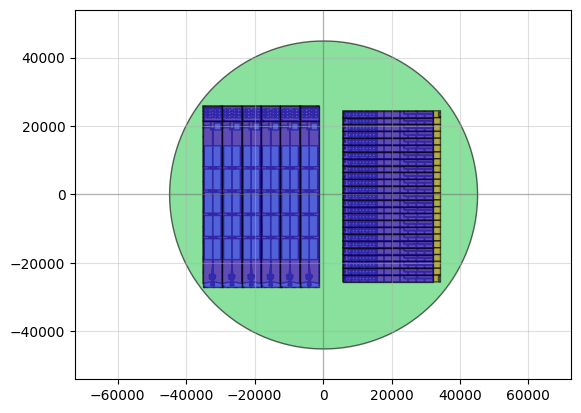

In [38]:
with open("chip_names_coupler.txt", "r") as f:
    chip_names_read = [line.strip() for line in f.readlines()]
coupler_files = chip_names_read
coupler_width = 5650
# Import the GDS structure
for idx, file in enumerate(coupler_files):
    wafer, coupler_chip_obj = add_dxf_chip_to_wafer(wafer, file, path, coupler_width, idx, x_offset=-35000, y_offset=-27000,
                                                    add_bool = False)

    wafer = add_coupler_bbox_and_negative_mask(wafer, coupler_chip_obj, coupler_width, idx, xpos_offset=-35000, ypos_offset=-27000)
qp(wafer)

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


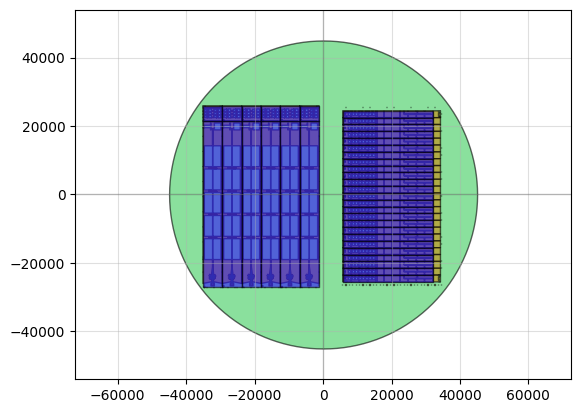

In [39]:
# coupler ebeam markers extended over right 
# draw squares of 80 micron at a set of x intervals on layer 5 
import numpy as np
def add_ebeam_markers(wafer, xpos_offset, ypos_offset, x_intervals, marker_size=80, y_intervals=None):
    if y_intervals is None:
        y_intervals = [0]
    for y in y_intervals:
        for x in x_intervals:
            xpos = xpos_offset + x
            ypos = ypos_offset + y
            marker = pg.rectangle(size=(marker_size, marker_size), layer=5)
            wafer << marker.move((xpos, ypos))
    return wafer

xpos_offset = 5500
ypos_offset_down = -26260-80
ypos_offset_up = 25640-80
x_intervals= np.arange(0, 30000, 1000)

# horizontal ebeam markers
wafer = add_ebeam_markers(wafer, xpos_offset, ypos_offset_down, x_intervals)
wafer = add_ebeam_markers(wafer, xpos_offset, ypos_offset_up, x_intervals)

# vertical 
y_intervals = np.arange(1000, ypos_offset_up-ypos_offset_down, 1000)

wafer = add_ebeam_markers(wafer,xpos_offset + x_intervals[-1],ypos_offset_down, [0], y_intervals=y_intervals, marker_size=80)
qp(wafer)


In [40]:
y_intervals

array([ 1000,  2000,  3000,  4000,  5000,  6000,  7000,  8000,  9000,
       10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000, 18000,
       19000, 20000, 21000, 22000, 23000, 24000, 25000, 26000, 27000,
       28000, 29000, 30000, 31000, 32000, 33000, 34000, 35000, 36000,
       37000, 38000, 39000, 40000, 41000, 42000, 43000, 44000, 45000,
       46000, 47000, 48000, 49000, 50000, 51000])

### Adding coherence resonators

In [41]:
folder_comm_service = "C:\\Users\\eeshg\\Documents\\multimode_sims\\Design\\coupler\\LMM3_Dravid\\community_service\\"

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


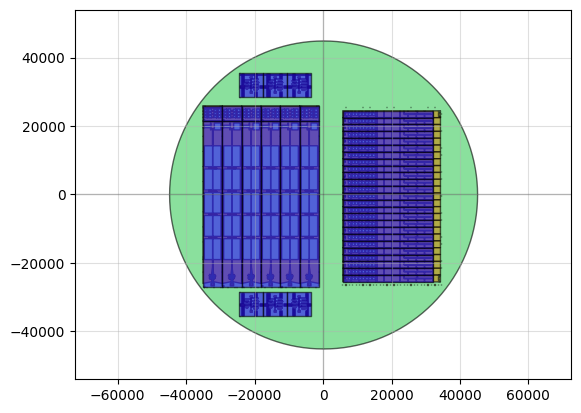

In [42]:
import numpy as np
import phidl.geometry as pg
import phidl.device_layout as pdl # Assuming Device or Cell objects might be from here
# import phidl.quickplot as qp

def add_coherence_resonators(
    wafer_device,
    x_offset,
    y_offset,
    num_resonators,
    resonator_gds=folder_comm_service + "center_feedline_resonator_5.gds",
    bbox_size=7000,
    spacing=None
):
    blank_params = {'size': 7000}
    if spacing is None:
        spacing = 7000

    # Initialize arrays for X and Y coordinates
    blank_x_arr = np.array([-31000] * num_resonators)
    blank_y_arr = np.array([27000] * num_resonators)

    blank_x_arr = blank_x_arr - bbox_size / 2 + x_offset
    blank_y_arr = blank_y_arr - bbox_size / 2 + y_offset
    blank_x_arr = [blank_x_arr[i] + (i) * spacing for i in range(num_resonators)]

    for i in range(num_resonators):
        coh_res_raw = pg.import_gds(resonator_gds)
        coh_res_pos = pg.copy_layer(coh_res_raw, layer=5, new_layer=5)
        coh_res_bbox = pg.rectangle(size=(bbox_size, bbox_size), layer=13).move((-bbox_size / 2, -bbox_size / 2))
        dicing_lane_width = 0

        wafer_device << coh_res_pos.move((blank_x_arr[i] + bbox_size / 2, blank_y_arr[i] + bbox_size / 2))
        wafer_device << coh_res_bbox.move((blank_x_arr[i] + bbox_size / 2 - 50, blank_y_arr[i] + bbox_size / 2))

        xmax = coh_res_bbox.xmax
        xmin = coh_res_bbox.xmin
        ymax = coh_res_bbox.ymax
        ymin = coh_res_bbox.ymin

        coh_res_pos << pg.cross(length=250, width=100, layer=3).move((xmax + dicing_lane_width / 2, ymax + dicing_lane_width / 2))
        coh_res_pos << pg.cross(length=250, width=100, layer=3).move((xmax + dicing_lane_width / 2, ymin - dicing_lane_width / 2))
        coh_res_pos << pg.cross(length=250, width=100, layer=3).move((xmin - dicing_lane_width / 2, ymax + dicing_lane_width / 2))
        coh_res_pos << pg.cross(length=250, width=100, layer=3).move((xmin - dicing_lane_width / 2, ymin - dicing_lane_width / 2))

add_coherence_resonators(wafer_device=wafer,
                         x_offset=10000,
                            y_offset=-59000,
                            num_resonators=3,
                            resonator_gds=folder_comm_service+"center_feedline_resonator_5.gds",
                            bbox_size=7000,)

add_coherence_resonators(wafer_device=wafer,
                         x_offset=10000,
                            y_offset=5000,
                            num_resonators=3,
                            resonator_gds=folder_comm_service+"center_feedline_resonator_5.gds",
                            bbox_size=7000,)
# add_coherence_resonators(wafer_device=wafer,
#                          x_offset=42000,
#                             y_offset=-32000 - 8000*2,
#                             num_resonators=4,
#                             resonator_gds="center_feedline_resonator_5.gds",
#                             bbox_size=7000,)
qp(wafer)
# wafer.write_gds("wafer_with_imported_dxf.gds")

### Coherence Qubits 

In [78]:
q_file_1 = "C:\\Users\\eeshg\\Documents\\multimode_sims\\Design\\coupler\\LMM3_Dravid\\community_service\\SiQbv2_wide_JJ_EEEEEEESH_jc0.1_offset0.0 (1)_mod.gds"
q_file_2 = "C:\\Users\\eeshg\\Documents\\multimode_sims\\Design\\coupler\\LMM3_Dravid\\community_service\\SiQbv2_wide_JJ_EEEEEEESH_jc0.2_offset0.0 (1).gds"
q_file_3 = "C:\\Users\\eeshg\\Documents\\multimode_sims\\Design\\coupler\\LMM3_Dravid\\community_service\\SiQbv2_wide_JJ_EEEEEEESH_jc0.3_offset0.0 (1).gds"
q_file_4 = r"C:\Users\eeshg\Documents\multimode_sims\Design\coupler\LMM3_Dravid\community_service\SiQbv2_wide_JJ_EEEEEEESH_jc0.1_offset0.0_mod.gds"

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


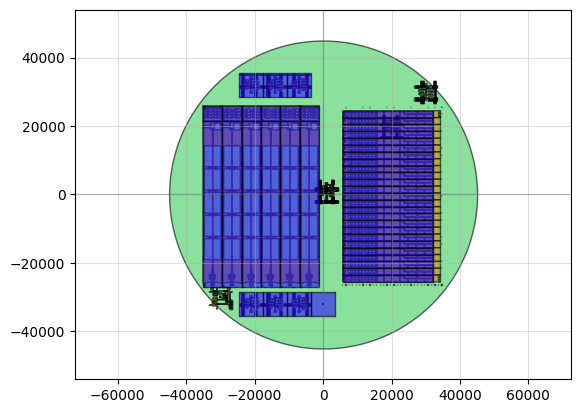

In [79]:
# coh_res_raw = pg.import_gds(folder_comm_service+"center_feedline_resonator_5.gds")
coh_res_raw = pg.import_gds(q_file_4)
# coh_res_raw.layers
coh_res_pos = pg.copy_layer(coh_res_raw, layer=5, new_layer=5)
wafer<< coh_res_pos.move((-30000,-30000))
qp(wafer)


In [72]:
coh_res_raw.layers

{np.int64(5), np.int64(20), np.int64(60), np.int64(299), np.int64(699)}

In [ ]:
def add_coherence_qubits(
    wafer_device,
    x_offset,
    y_offset,
    num_resonators,
    resonator_gds=folder_comm_service + "center_feedline_resonator_5.gds",
    bbox_size=7000,
    spacing=None
):
    blank_params = {'size': 7000}
    if spacing is None:
        spacing = 7000

    # Initialize arrays for X and Y coordinates
    blank_x_arr = np.array([-31000] * num_resonators)
    blank_y_arr = np.array([27000] * num_resonators)

    blank_x_arr = blank_x_arr - bbox_size / 2 + x_offset
    blank_y_arr = blank_y_arr - bbox_size / 2 + y_offset
    blank_x_arr = [blank_x_arr[i] + (i) * spacing for i in range(num_resonators)]

    for i in range(num_resonators):
        coh_res_raw = pg.import_gds(resonator_gds)
        coh_res_pos = pg.copy_layer(coh_res_raw, layer=5, new_layer=5)
        coh_res_bbox = pg.rectangle(size=(bbox_size, bbox_size), layer=13).move((-bbox_size / 2, -bbox_size / 2))
        dicing_lane_width = 0

        wafer_device << coh_res_pos.move((blank_x_arr[i] + bbox_size / 2, blank_y_arr[i] + bbox_size / 2))
        wafer_device << coh_res_bbox.move((blank_x_arr[i] + bbox_size / 2 - 50, blank_y_arr[i] + bbox_size / 2))

        xmax = coh_res_bbox.xmax
        xmin = coh_res_bbox.xmin
        ymax = coh_res_bbox.ymax
        ymin = coh_res_bbox.ymin

        coh_res_pos << pg.cross(length=250, width=100, layer=3).move((xmax + dicing_lane_width / 2, ymax + dicing_lane_width / 2))
        coh_res_pos << pg.cross(length=250, width=100, layer=3).move((xmax + dicing_lane_width / 2, ymin - dicing_lane_width / 2))
        coh_res_pos << pg.cross(length=250, width=100, layer=3).move((xmin - dicing_lane_width / 2, ymax + dicing_lane_width / 2))
        coh_res_pos << pg.cross(length=250, width=100, layer=3).move((xmin - dicing_lane_width / 2, ymin - dicing_lane_width / 2))


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


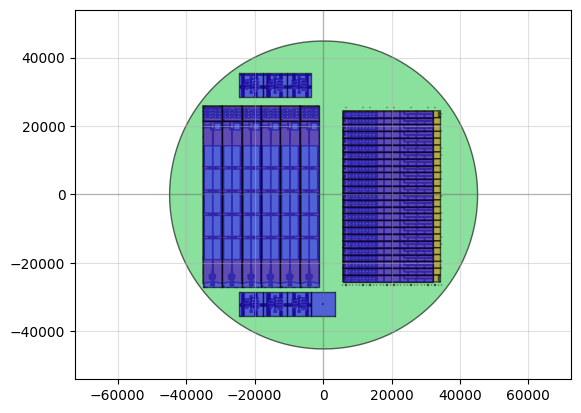

In [44]:
add_coherence_resonators(wafer_device=wafer,
                         x_offset=10000 + 7000*3,
                            y_offset=-59000,
                            num_resonators=1,
                            resonator_gds=q_file_1,
                            bbox_size=7000,)

# add_coherence_resonators(wafer_device=wafer,
#                          x_offset=10000,
#                             y_offset=5000,
#                             num_resonators=3,
#                             resonator_gds=folder_comm_service+"center_feedline_resonator_5.gds",
#                             bbox_size=7000,)
qp(wafer)

In [45]:
# Add Qubit GDS

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


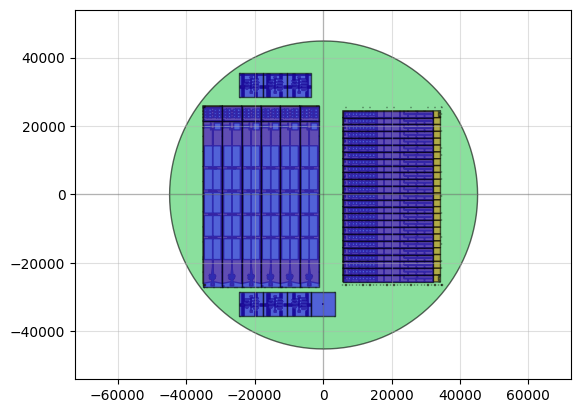

In [46]:
# Using Phidl draw a cross mark with line width of 20 micro at given point. Make a function . 
def draw_cross_mark(center=(0, 0), arm_length=100, line_width=20, layer=10):
    """
    Draws a cross mark centered at the given point.
    Args:
        center: tuple (x, y) for the center of the cross
        arm_length: length of each arm from center (um)
        line_width: width of the lines (um)
        layer: GDS layer to draw on
    Returns:
        phidl Device containing the cross mark
    """
    D = Device("cross_mark")
    x, y = center
    # Horizontal line
    h_line = pg.rectangle(size=(2 * arm_length, line_width), layer=layer)
    D << h_line.move((x - arm_length, y - line_width / 2))
    # Vertical line
    v_line = pg.rectangle(size=(line_width, 2 * arm_length), layer=layer)
    D << v_line.move((x - line_width / 2, y - arm_length))
    return D

# Example usage of draw_cross_mark
alignement_points = [(-34800, -26300), (-34800, 25600), (34540, 25600), (34540, -26300)]
for point in alignement_points:
    cross_mark = draw_cross_mark(center=(0,0), arm_length=160, line_width=20, layer=15)
    wafer << cross_mark.move(point)  # Place the cross mark at the specified point
# cross_mark = draw_cross_mark(center=(0, 0), arm_length=160, line_width=20, layer=10)
# wafer << cross_mark.move((0, 0))  # Place the cross mark at the origin
qp(wafer)  # Quick preview of the wafer with the cross mark

# Saving

In [80]:
wafer.write_gds("SirajOptical_dicing.gds")

'SirajOptical_dicing.gds'